
### 1. 导入所需库


In [19]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
from PIL import Image
import os



### 2. 数据加载函数


In [20]:
def data_load(data_dir, img_height, img_width, batch_size, num_workers=8):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = ImageFolder(root=data_dir, transform=transform)
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    
    class_names = dataset.classes
    return loader, class_names



### 3. 定义CNN模型


In [21]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 28 * 28, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



### 4. 测试函数


In [22]:
def test_model(model, test_loader, device):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    return y_true, y_pred



### 5. 绘制混淆矩阵


In [23]:
def plot_confusion_matrix(y_true, y_pred, class_names):
    cf_matrix = confusion_matrix(y_true, y_pred)
    cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]  # 转换为百分比
    df_cm = pd.DataFrame(cf_matrix, index=[i for i in class_names], columns=[i for i in class_names])
    plt.figure(figsize=(12, 7))
    sns.heatmap(df_cm, annot=True, fmt='.1%', cmap='Blues')  # 显示为百分比
    plt.xlabel('prediction label')
    plt.ylabel('real label')
    plt.title(' confusion matrix')
    plt.savefig('cnn_confusion_matrix_percentage.png', dpi=100)



### 6. 主函数


C:\Users\lenovo\AppData\Local\Temp\ipykernel_45312\3805800059.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=

Test Accuracy: 0.77


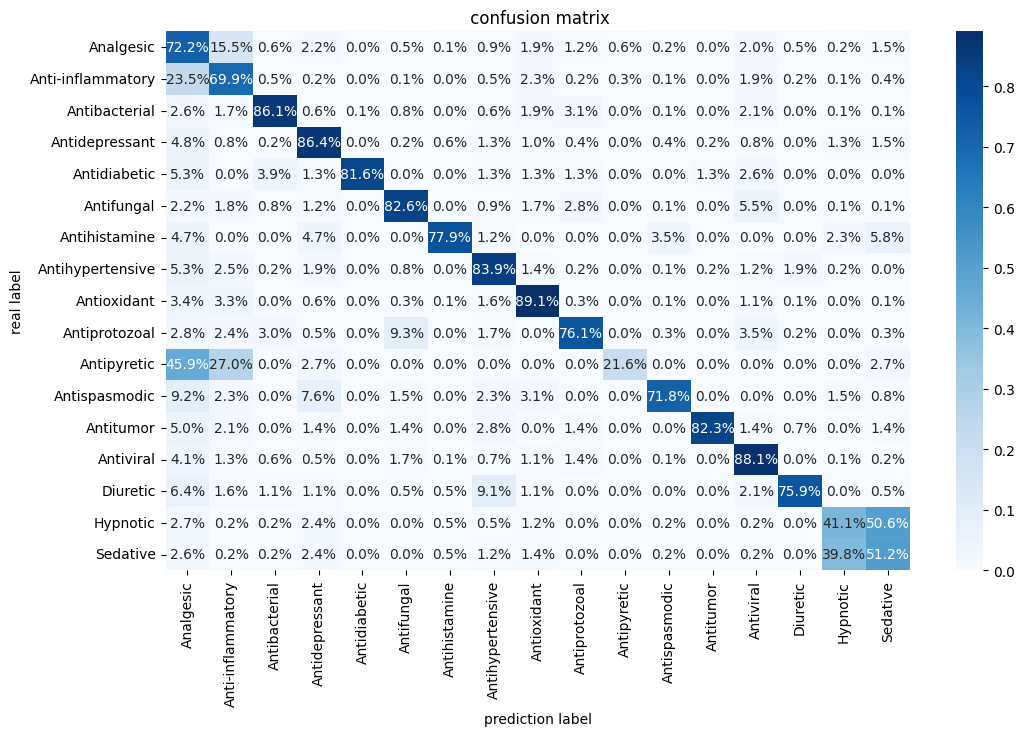

In [24]:
if __name__ == '__main__':
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    
    img_size = 224
    batch_size = 32
    test_data_dir = r"E:\code\Jupyter\final_repo\pics"  # 测试数据集路径
    model_path = r"E:\code\Jupyter\final_repo\CNN_Model.pth"  # 模型权重路径
    test_loader, class_names = data_load(test_data_dir, img_size, img_size, batch_size)
   
    model = SimpleCNN(num_classes=len(class_names)).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))  # 加载之前训练的模型权重
    
    y_true, y_pred = test_model(model, test_loader, device)
    
    test_accuracy = np.sum(np.array(y_true) == np.array(y_pred)) / len(y_true)
    print(f"Test Accuracy: {test_accuracy:.2f}")
    plot_confusion_matrix(y_true, y_pred, class_names)